# Analysis of Dynamometer Card Tables

This notebook contains codes and functions to run queries to analyze and understand data present in he dynocard dataset:

**DEV DB:**
- Database Name: oasis-dev
- Schema Name : xspoc
- Table Name: card

**Main DB:**
- Database Name: oasis-data
- Schema Name : xspoc_dbo
- Table Name: tblCardData

*Note: For NodeID 'Spratley 5494 14-13 15T' data has not been transferred yet. Once issues are resolved it will be done*


In [1]:
"""
For setting up local imports in an Ipython Shell
This is a workaround for ipython, dont need it for basic python scripts
"""
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import numpy as np
import struct
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon
from shapely.wkb import loads

# Project Library
from library.lib_aws import PostgresRDS
from library import lib_dyna, lib_aws

In [3]:
"""
Dyna Functions
Note: Once Testing done will be moved to the lib_dyna file
"""
# Plotting
"""
Plotting
"""

def dyna_plot(poly_arr, name, fill=True, color=None, fig_labels=None, set_axis=None, save=None, show=True, legend=True):
    """
    Plots the card
    """

    if color is None:
        cmap = plt.cm.get_cmap('tab20b', len(poly_arr))  # Gets a listed cmap with standard mpl cmap name 
        color = cmap.colors
    
    if fig_labels is None: # if fig_labels not provided
        fig_labels = range(len(poly_arr))

    fig_clean, ax_clean = plt.subplots()  # set up the figure
    
    for i in range(len(poly_arr)):  # Iterate over each of the polygons in the poly arr
        xy = np.asarray(poly_arr[i].exterior.coords)  # Get co-ordinates
        
        if fill:
            ax_clean.fill(xy[:,0], xy[:,1], facecolor=color[i], label=str(fig_labels[i]))
        else:
            ax_clean.plot(xy[:,0], xy[:,1], c=color[i], label=str(fig_labels[i]))

    if set_axis:
        ax_clean.set_ylim(set_axis)

#     plt.axis('off')
    fig_clean.set_size_inches(12, 8)
    fig_clean.patch.set_facecolor('w')
    plt.title(name)
    
    if legend:
        plt.legend(loc='best')
    
    if save:
        save_name = os.path.join(save, name + ".png")
        plt.savefig(save_name, dpi=50, bbox_inches='tight')
    
    if show:
        plt.show()
    
    plt.close()

## DataSet Info

In [4]:
#Setup
database = 'oasis-dev'

In [5]:
query = """SELECT DISTINCT "NodeID" from xspoc.card ORDER BY "NodeID";"""

cols_query = """
SELECT attname            AS col
     , atttypid::regtype  AS datatype
       -- more attributes?
FROM   pg_attribute
WHERE  attrelid = 'xspoc.card'::regclass  -- table name, optionally schema-qualified
AND    attnum > 0
AND    NOT attisdropped
ORDER  BY attnum;
"""
with PostgresRDS(db=database) as engine:
    well_list = pd.read_sql(query, engine)
    col_list = pd.read_sql(cols_query, engine)

Connected to oasis-dev DataBase
Connection Closed


In [6]:
print("List of Columns")
display(col_list)

print("\nList of Wells")
display(well_list)

List of Columns


,col,datatype
0,NodeID,text
1,Date,timestamp without time zone
2,pocdowncard,geometry
3,surfcard,geometry
4,downcard,geometry
5,PredictedCardB,geometry
6,TorquePlotMinEnergyB,geometry
7,TorquePlotMinTorqueB,geometry
8,TorquePlotCurrentB,geometry
9,PermissibleLoadUpB,geometry



List of Wells


,NodeID
0,Bonner 9-12H
1,Bonner 9X-12HA
2,Bonner 9X-12HB
3,Cade 12-19HA
4,Cade 12-19HB
5,Cade 12X-19H
6,Cook 12-13 6B
7,Cook 12-13 7T
8,Cook 12-13 9T
9,Cook 41-12 11T


## Well Specific

- Queries for a single well.
- Specify the card columns (geometry dtype) in col_list if those cards are being queried.
- Add or delete columns

In [5]:
well_name = 'Spratley 5494 14-13 13T'  # Select WellName
card_cols = ['pocdowncard', 'surfcard', "PredictedCardB"]  # Specify the dyna column names

# Can play around with the columns in the query
query = """
SELECT 
"NodeID",
"Date",
pocdowncard,
surfcard,
"PredictedCardB",
"SPM",
"Fillage",
"FillBasePct",
"CauseID"
FROM xspoc.card
WHERE "NodeID" = '{}'
ORDER BY "NodeID" , "Date";
""".format(well_name)

with PostgresRDS(db=database) as engine:
    data = pd.read_sql(query, engine)

for c in card_cols:
    data.loc[:, c] = data.loc[:, c].apply(lambda x: loads(x, hex=True))
    
display(data.head())

Connected to oasis-dev DataBase
Connection Closed


,NodeID,Date,pocdowncard,surfcard,PredictedCardB,SPM,Fillage,FillBasePct,CauseID
0,Spratley 5494 14-13 13T,2019-08-30 12:05:08,"POLYGON ((14.07999992370605 -8367, 7.309999942...","POLYGON ((0.550000011920929 25492, 1.100000023...","POLYGON ((0 0, 0 0, 0 0, 0 0))",3.4,96.3,45,137
1,Spratley 5494 14-13 13T,2019-08-30 12:15:52,"POLYGON ((11.22999954223633 -7640, 5.289999961...","POLYGON ((0.6200000047683716 25200, 1.24000000...","POLYGON ((0 0, 0 0, 0 0, 0 0))",2.5,99.1,45,99
2,Spratley 5494 14-13 13T,2019-08-30 14:41:36,"POLYGON ((12.44999980926514 -8333, 5.989999771...","POLYGON ((0.5400000214576721 26106, 1.09000003...","POLYGON ((0 0, 0 0, 0 0, 0 0))",3.3,97.7,45,99
3,Spratley 5494 14-13 13T,2019-08-30 17:42:22,"POLYGON ((11.60000038146973 -8069, 5.489999771...","POLYGON ((0.5400000214576721 26005, 1.09000003...","POLYGON ((0 0, 0 0, 0 0, 0 0))",3.3,98.6,45,99
4,Spratley 5494 14-13 13T,2019-08-30 20:42:35,"POLYGON ((12.69999980926514 -8371, 7.070000171...","POLYGON ((0.550000011920929 24688, 1.100000023...","POLYGON ((0 0, 0 0, 0 0, 0 0))",3.3,88.7,45,99


## Multiple wells

Uncomment the bottom cell to query multiple wells

In [6]:
data.head()

,NodeID,Date,pocdowncard,surfcard,PredictedCardB,SPM,Fillage,FillBasePct,CauseID
0,Spratley 5494 14-13 13T,2019-08-30 12:05:08,"POLYGON ((14.07999992370605 -8367, 7.309999942...","POLYGON ((0.550000011920929 25492, 1.100000023...","POLYGON ((0 0, 0 0, 0 0, 0 0))",3.4,96.3,45,137
1,Spratley 5494 14-13 13T,2019-08-30 12:15:52,"POLYGON ((11.22999954223633 -7640, 5.289999961...","POLYGON ((0.6200000047683716 25200, 1.24000000...","POLYGON ((0 0, 0 0, 0 0, 0 0))",2.5,99.1,45,99
2,Spratley 5494 14-13 13T,2019-08-30 14:41:36,"POLYGON ((12.44999980926514 -8333, 5.989999771...","POLYGON ((0.5400000214576721 26106, 1.09000003...","POLYGON ((0 0, 0 0, 0 0, 0 0))",3.3,97.7,45,99
3,Spratley 5494 14-13 13T,2019-08-30 17:42:22,"POLYGON ((11.60000038146973 -8069, 5.489999771...","POLYGON ((0.5400000214576721 26005, 1.09000003...","POLYGON ((0 0, 0 0, 0 0, 0 0))",3.3,98.6,45,99
4,Spratley 5494 14-13 13T,2019-08-30 20:42:35,"POLYGON ((12.69999980926514 -8371, 7.070000171...","POLYGON ((0.550000011920929 24688, 1.100000023...","POLYGON ((0 0, 0 0, 0 0, 0 0))",3.3,88.7,45,99


In [188]:
%%time
# Add wells to the list
well_list = [
    'Bonner 9-12H',
    'Bonner 9X-12HA',
    'Bonner 9X-12HB'
]

card_cols = ['pocdowncard', 'surfcard']

# Modify the query to get reqd columns
query = """
select 
"NodeID",
"Date",
pocdowncard,
surfcard,
"SPM",
"Fillage",
"FillBasePct" 
from xspoc.card
where "NodeID" in {}
order by "NodeID", "Date"
""".format(tuple(well_list))

with PostgresRDS(db=database) as engine:
    data = pd.read_sql(query, engine)

for c in card_cols:
    data.loc[:, c] = data.loc[:, c].apply(lambda x: loads(x, hex=True))
    
display(data.head())

Connected to oasis-dev DataBase
Connection Closed


,NodeID,Date,pocdowncard,surfcard,SPM,Fillage,FillBasePct
0,Bonner 9-12H,2019-01-22 13:30:13,"POLYGON ((10.10000038146973 -8889, 25.12000083...","POLYGON ((0.6100000143051147 22700, 1.23000001...",2.0,98.1,45
1,Bonner 9-12H,2019-03-19 00:51:53,"POLYGON ((6.53000020980835 -8826, 21.870000839...","POLYGON ((0.6100000143051147 22578, 1.23000001...",2.0,99.0,45
2,Bonner 9-12H,2019-03-19 02:41:29,"POLYGON ((10.06999969482422 -8892, 22.12999916...","POLYGON ((0.6100000143051147 22700, 1.23000001...",2.0,91.0,45
3,Bonner 9-12H,2019-03-19 04:57:34,"POLYGON ((4.639999866485596 -9044, 17.45000076...","POLYGON ((0.6100000143051147 22116, 1.23000001...",2.0,99.8,45
4,Bonner 9-12H,2019-03-19 06:41:44,"POLYGON ((6.300000190734863 -8971, 15.34000015...","POLYGON ((0.6100000143051147 21344, 1.23000001...",1.2,100.0,45


Wall time: 48.9 s


## Plotting

In [10]:
data.loc[:, 'pocdowncard']

0       POLYGON ((14.07999992370605 -8367, 7.309999942...
1       POLYGON ((11.22999954223633 -7640, 5.289999961...
2       POLYGON ((12.44999980926514 -8333, 5.989999771...
3       POLYGON ((11.60000038146973 -8069, 5.489999771...
4       POLYGON ((12.69999980926514 -8371, 7.070000171...
                              ...                        
1423    POLYGON ((12.25 -8492, 6.139999866485596 -8331...
1424    POLYGON ((9.840000152587891 -8658, 4.369999885...
1425    POLYGON ((13.57999992370605 -8254, 7.409999847...
1426    POLYGON ((8.239999771118164 -8224, 4.650000095...
1427    POLYGON ((14.4399995803833 -8541, 8.0299997329...
Name: pocdowncard, Length: 1428, dtype: object

NodeID                                      Spratley 5494 14-13 13T
Date                                            2019-09-14 08:54:13
pocdowncard       POLYGON ((14.9399995803833 -8390, 7.8000001907...
surfcard          POLYGON ((0.550000011920929 25016, 1.100000023...
PredictedCardB                       POLYGON ((0 0, 0 0, 0 0, 0 0))
SPM                                                             3.3
Fillage                                                        96.7
FillBasePct                                                      45
CauseID                                                          99
Name: 112, dtype: object


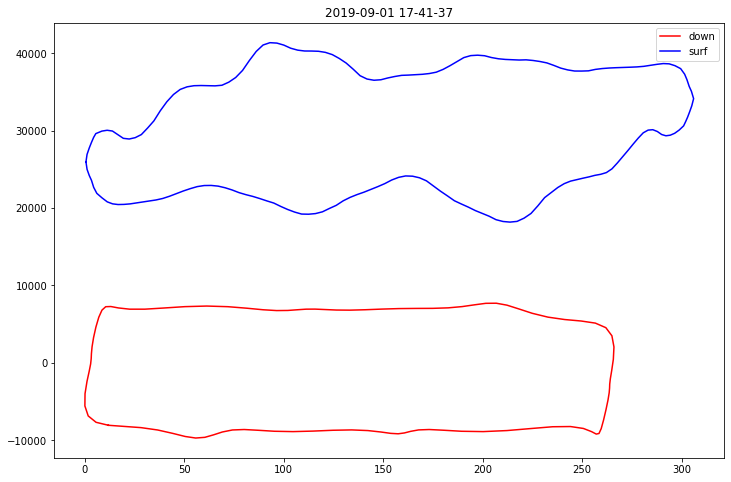

In [7]:
"""
Test the dyna_plot function
"""
index = 11
card_cols = ['pocdowncard', 'surfcard']  # select the geometry to plot
well, date= data.loc[index, ['NodeID', 'Date']]

cards = data.loc[index, card_cols].to_list()

print(data.loc[112])

name = date.strftime('%Y-%m-%d %H-%M-%S')
dyna_plot(cards, name, fill=False, set_axis=None, color=['r', 'b', 'g'],save=None, show=True, fig_labels = ['down', 'surf', 'pred'])



In [128]:
"""
Save
"""

save_path = r"/path"
card_cols = ['pocdowncard']  # Select the geometry column

for i in well_data.index[0:10]:
    well, date = well_data.loc[i, ['NodeID', 'Date']]
    cards = well_data.loc[i, card_cols].to_list()
    date = pd.to_datetime(str(date))
    name = date.strftime('%Y-%m-%d %H-%M-%S')
    
    dyna_plot(cards, name, fill=False, color=['DARKGREEN'], set_axis=None, save=None, show=None) 


## Making Predictions

Use the algo built for bonanza, which is stored in the s3 bucket, 'et-bonanza/algo/rfcMultiModel'.
The s3 bucket name is stored in the `config.py` file.

In [193]:
# Get features for the current dataset
# Using only FD, Area and Centroid
# Class Features from lib_dyna is used. Use help command to see details or shift+tab
fea = lib_dyna.Features(df=data,
                       card_col='pocdowncard',
                       well_col='NodeID')
fea.remove_errors()
full_bounds = fea.all_bounds()
X = fea.get_X(fd_order=5, area=True, centroid=True, 
              normalize_fn='df', norm_arg=full_bounds)

c:\users\rai_v\onedrive\python coursera\oasis\venv\lib\site-packages\pyefd.py:53: RuntimeWarning: invalid value encountered in true_divide
  phi = (2 * np.pi * t) / T
c:\users\rai_v\onedrive\python coursera\oasis\venv\lib\site-packages\pyefd.py:60: RuntimeWarning: invalid value encountered in true_divide
  cos_phi = (dxy[:, 0] / dt) * d_cos_phi
c:\users\rai_v\onedrive\python coursera\oasis\venv\lib\site-packages\pyefd.py:62: RuntimeWarning: invalid value encountered in true_divide
  b = consts * np.sum((dxy[:, 0] / dt) * d_sin_phi, axis=1)
c:\users\rai_v\onedrive\python coursera\oasis\venv\lib\site-packages\pyefd.py:63: RuntimeWarning: invalid value encountered in true_divide
  c = consts * np.sum((dxy[:, 1] / dt) * d_cos_phi, axis=1)
c:\users\rai_v\onedrive\python coursera\oasis\venv\lib\site-packages\pyefd.py:64: RuntimeWarning: invalid value encountered in true_divide
  d = consts * np.sum((dxy[:, 1] / dt) * d_sin_phi, axis=1)


In [194]:
# Get the trained Model
# Importing the model from an s3 bucket
model, mlb = lib_aws.import_model('algo/rfcMultiModel.pkl')  

In [195]:
# Make Predictions
pred = lib_dyna.Predictions_MultiLabel(model=model,
                                           x=X,
                                           mlb=mlb)
pred_data = pred.get_pred_df(n=2)  # Get 2 labels as predictions
full_pred = pd.concat([fea.df, pred_data], axis=1)  # Get the prediction DataFrame

full_pred.head()

,NodeID,Date,pocdowncard,surfcard,SPM,Fillage,FillBasePct,Label1,Prob1,Label2,Prob2
0,Bonner 9-12H,2019-01-22 13:30:13,"POLYGON ((10.10000038146973 -8889, 25.12000083...","POLYGON ((0.6100000143051147 22700, 1.23000001...",2.0,98.1,45,Tubing Movement,52.0,Pump Tagging Up,18.0
1,Bonner 9-12H,2019-03-19 00:51:53,"POLYGON ((6.53000020980835 -8826, 21.870000839...","POLYGON ((0.6100000143051147 22578, 1.23000001...",2.0,99.0,45,Tubing Movement,58.0,Pump Tagging Up,20.0
2,Bonner 9-12H,2019-03-19 02:41:29,"POLYGON ((10.06999969482422 -8892, 22.12999916...","POLYGON ((0.6100000143051147 22700, 1.23000001...",2.0,91.0,45,Gas Interference,34.0,Tubing Movement,20.0
3,Bonner 9-12H,2019-03-19 04:57:34,"POLYGON ((4.639999866485596 -9044, 17.45000076...","POLYGON ((0.6100000143051147 22116, 1.23000001...",2.0,99.8,45,Tubing Movement,56.0,Pump Tagging Up,21.0
4,Bonner 9-12H,2019-03-19 06:41:44,"POLYGON ((6.300000190734863 -8971, 15.34000015...","POLYGON ((0.6100000143051147 21344, 1.23000001...",1.2,100.0,45,Tubing Movement,46.0,Pump Tagging Up,23.0


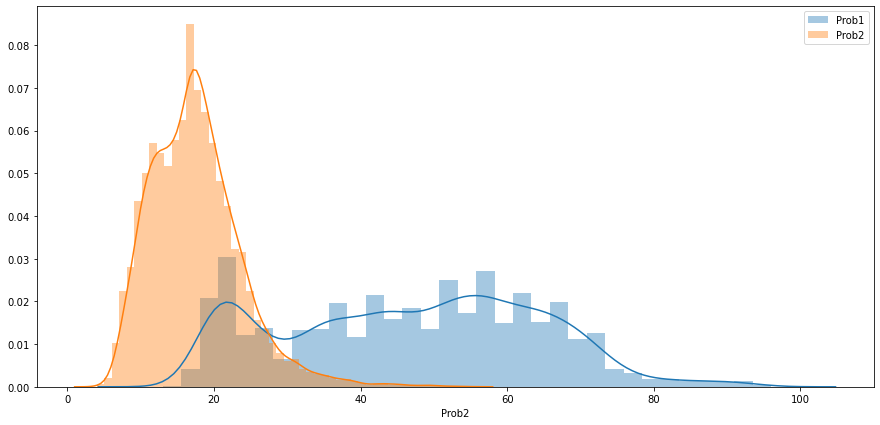

In [196]:
# Plot the distribution of the probabilities
# The more probabilites above 50% the better the algo is being abled to classify
fig, ax = plt.subplots(figsize=(15,7))
sns.distplot(full_pred['Prob1'], label="Prob1")
sns.distplot(full_pred['Prob2'], label="Prob2")
plt.legend()
fig.patch.set_facecolor('w')
plt.show()

In [197]:
# Find Prob whcih were greater than a thresh
full_pred

,NodeID,Date,pocdowncard,surfcard,SPM,Fillage,FillBasePct,Label1,Prob1,Label2,Prob2
0,Bonner 9-12H,2019-01-22 13:30:13,"POLYGON ((10.10000038146973 -8889, 25.12000083...","POLYGON ((0.6100000143051147 22700, 1.23000001...",2.0,98.1,45,Tubing Movement,52.0,Pump Tagging Up,18.0
1,Bonner 9-12H,2019-03-19 00:51:53,"POLYGON ((6.53000020980835 -8826, 21.870000839...","POLYGON ((0.6100000143051147 22578, 1.23000001...",2.0,99.0,45,Tubing Movement,58.0,Pump Tagging Up,20.0
2,Bonner 9-12H,2019-03-19 02:41:29,"POLYGON ((10.06999969482422 -8892, 22.12999916...","POLYGON ((0.6100000143051147 22700, 1.23000001...",2.0,91.0,45,Gas Interference,34.0,Tubing Movement,20.0
3,Bonner 9-12H,2019-03-19 04:57:34,"POLYGON ((4.639999866485596 -9044, 17.45000076...","POLYGON ((0.6100000143051147 22116, 1.23000001...",2.0,99.8,45,Tubing Movement,56.0,Pump Tagging Up,21.0
4,Bonner 9-12H,2019-03-19 06:41:44,"POLYGON ((6.300000190734863 -8971, 15.34000015...","POLYGON ((0.6100000143051147 21344, 1.23000001...",1.2,100.0,45,Tubing Movement,46.0,Pump Tagging Up,23.0
...,...,...,...,...,...,...,...,...,...,...,...
9492,Bonner 9X-12HB,2020-04-09 16:28:59,"POLYGON ((7.489999771118164 -9112, 10.77000045...","POLYGON ((0.3600000143051147 20331, 0.70999997...",2.1,95.0,45,Tubing Movement,51.0,Pump Tagging Up,11.0
9493,Bonner 9X-12HB,2020-04-09 19:29:00,"POLYGON ((6.300000190734863 -9020, 8.899999618...","POLYGON ((0.3600000143051147 20373, 0.70999997...",2.1,95.6,45,Tubing Movement,34.0,Pump Tagging Up,16.0
9494,Bonner 9X-12HB,2020-04-09 22:29:59,"POLYGON ((5.920000076293945 -8840, 8.850000381...","POLYGON ((0.3499999940395355 20531, 0.70999997...",2.1,70.6,45,Gas Interference,24.0,Pump Tagging Down,14.0
9495,Bonner 9X-12HB,2020-04-10 01:42:05,"POLYGON ((5.179999828338623 -8852, 8.779999732...","POLYGON ((0.3499999940395355 20638, 0.70999997...",2.1,93.6,45,Tubing Movement,53.0,Pump Tagging Up,8.0


NodeID         Bonner 9X-12HB
Date      2019-10-22 03:06:02
Label1        Tubing Movement
Prob1                      21
Label2        Pump Tagging Up
Prob2                      17
Name: 7890, dtype: object


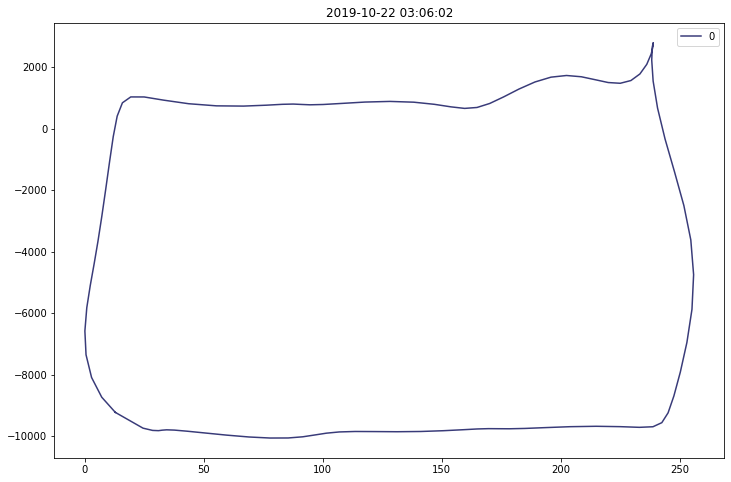

In [202]:
# Plot 
index = 7890
card_cols = ['pocdowncard']  # select the geometry to plot
date = full_pred.loc[index, 'Date']
cards = full_pred.loc[index, card_cols].to_list()

print(full_pred.loc[index, ['NodeID', 'Date', 'Label1', 'Prob1', 'Label2', 'Prob2']])

name = date.strftime('%Y-%m-%d %H-%M-%S')
dyna_plot(cards, name=date, fill=False, set_axis=None, save=None, show=True)

## Get the pump condition from xdiagresults

Use the same wells as used before

In [203]:
# query = """
# SELECT "NodeID", "Date", "PumpCondition" from xspoc.xdiagresults 
# WHERE "NodeID" = '{}'
# ORDER BY "NodeID", "Date"
# """.format(well_name)

# Uncomment if using multiple wells
query = """
SELECT "NodeID", "Date", "PumpCondition" 
from xspoc.xdiagresults 
WHERE "NodeID" in {}
ORDER BY "NodeID", "Date"
""".format(tuple(well_list))

with lib_aws.PostgresRDS(db=database) as engine:
    xdiag = pd.read_sql(query, engine)

display(xdiag.head())

Connected to oasis-dev DataBase
Connection Closed


,NodeID,Date,PumpCondition
0,Bonner 9-12H,2019-07-12 09:43:39,None
1,Bonner 9-12H,2019-07-12 12:20:58,Full pump.
2,Bonner 9-12H,2019-07-12 12:25:28,None
3,Bonner 9-12H,2019-07-14 09:06:04,Full pump.
4,Bonner 9-12H,2019-07-14 10:59:27,Gas interference. High rod-tubing friction.


In [204]:
# Basic Cleaning on the labels
# Dropping those columns which have more than 99% nan values
xdiag['Xlabel1'] = xdiag.PumpCondition.str.split('.', expand=True)[0].str.strip()
xdiag.loc[xdiag.Xlabel1 == '', 'Xlabel1'] = np.nan

xdiag['Xlabel2'] = xdiag.PumpCondition.str.split('.', expand=True)[1].str.strip()
xdiag.loc[xdiag.Xlabel2 == '', 'Xlabel2'] = np.nan

xdiag['Xlabel3'] = xdiag.PumpCondition.str.split('.', expand=True)[2].str.strip()
xdiag.loc[xdiag.Xlabel3 == '', 'Xlabel3'] = np.nan

xdiag.fillna(np.nan, inplace=True)
non_nan_limit = int(xdiag.shape[0] * 0.01)
xdiag.dropna(axis=1, thresh = non_nan_limit, inplace=True)
xdiag.drop(columns = ['PumpCondition'], inplace=True)

display(xdiag.head())


,NodeID,Date,Xlabel1,Xlabel2
0,Bonner 9-12H,2019-07-12 09:43:39,NaN,NaN
1,Bonner 9-12H,2019-07-12 12:20:58,Full pump,NaN
2,Bonner 9-12H,2019-07-12 12:25:28,NaN,NaN
3,Bonner 9-12H,2019-07-14 09:06:04,Full pump,NaN
4,Bonner 9-12H,2019-07-14 10:59:27,Gas interference,High rod-tubing friction


In [206]:
xdiag.Xlabel2.value_counts()

Phase shift in dyno card                1630
High rod-tubing friction                 421
Anchor not holding                       251
Bent pump barrel or sticking plunger     224
Possible SV leak                         218
Pump hitting up                          193
Possible TV leak                          79
Worn pump barrel                          45
Worn pump                                 16
Possible TV and SV leaks                   2
SV leak                                    1
Severe SV leak                             1
Name: Xlabel2, dtype: int64

### Merging

In [213]:
# card data
data.set_index(['NodeID', "Date"], inplace=True)  # Og Data
full_pred.set_index(['NodeID', "Date"], inplace=True)  # Error Cards dropped and predictiopns from algo

# xdiag data
xdiag.set_index(['NodeID', "Date"], inplace=True)


In [215]:
full_pred.reindex(xdiag.index)

pocdowncard  \
NodeID         Date                                                                     
Bonner 9-12H   2019-07-12 09:43:39                                                NaN   
               2019-07-12 12:20:58  POLYGON ((9.260000228881836 -9559, 23.81999969...   
               2019-07-12 12:25:28  POLYGON ((10.59000015258789 -9534, 26.51000022...   
               2019-07-14 09:06:04  POLYGON ((9.310000419616699 -9174, 23.07999992...   
               2019-07-14 10:59:27  POLYGON ((8.569999694824219 -9358, 18.96999931...   
...                                                                               ...   
Bonner 9X-12HB 2020-04-09 16:28:59  POLYGON ((7.489999771118164 -9112, 10.77000045...   
               2020-04-09 19:29:00  POLYGON ((6.300000190734863 -9020, 8.899999618...   
               2020-04-09 22:29:59  POLYGON ((5.920000076293945 -8840, 8.850000381...   
               2020-04-10 01:42:05  POLYGON ((5.179999828338623 -8852, 8.779999732...   
               2020-04-10 04:31:11  POLYGON ((5.980000019073486 -8718, 9.75 -9372,...   

                                                                             surfcard  \
NodeID         Date                                                                     
Bonner 9-12H   2019-07-12 09:43:39                                                NaN   
               2019-07-12 12:20:58  POLYGON ((0.6100000143051147 21577, 1.23000001...   
               2019-07-12 12:25:28  POLYGON ((0.6100000143051147 21794, 1.23000001...   
               2019-07-14 09:06:04  POLYGON ((0.6200000047683716 22289, 1.24000000...   
               2019-07-14 10:59:27  POLYGON ((0.6100000143051147 21687, 1.23000001...   
...                                                                               ...   
Bonner 9X-12HB 2020-04-09 16:28:59  POLYGON ((0.3600000143051147 20331, 0.70999997...   
               2020-04-09 19:29:00  POLYGON ((0.3600000143051147 20373, 0.70999997...   
               2020-04-09 22:29:59  POLYGON ((0.3499999940395355 20531, 0.70999997...   
               2020-04-10 01:42:05  POLYGON ((0.3499999940395355 20638, 0.70999997...   
               2020-04-10 04:31:11  POLYGON ((0.3600000143051147 20662, 0.70999997...   

                                    SPM  Fillage  FillBasePct  \
NodeID         Date                                             
Bonner 9-12H   2019-07-12 09:43:39  NaN      NaN          NaN   
               2019-07-12 12:20:58  2.0     99.5         45.0   
               2019-07-12 12:25:28  2.0     99.4         45.0   
               2019-07-14 09:06:04  2.0     95.7         45.0   
               2019-07-14 10:59:27  2.0     87.8         45.0   
...                                 ...      ...          ...   
Bonner 9X-12HB 2020-04-09 16:28:59  2.1     95.0         45.0   
               2020-04-09 19:29:00  2.1     95.6         45.0   
               2020-04-09 22:29:59  2.1     70.6         45.0   
               2020-04-10 01:42:05  2.1     93.6         45.0   
               2020-04-10 04:31:11  2.1     28.4         45.0   

                                              Label1  Prob1  \
NodeID         Date                                           
Bonner 9-12H   2019-07-12 09:43:39               NaN    NaN   
               2019-07-12 12:20:58   Tubing Movement   52.0   
               2019-07-12 12:25:28   Tubing Movement   52.0   
               2019-07-14 09:06:04   Tubing Movement   35.0   
               2019-07-14 10:59:27  Gas Interference   33.0   
...                                              ...    ...   
Bonner 9X-12HB 2020-04-09 16:28:59   Tubing Movement   51.0   
               2020-04-09 19:29:00   Tubing Movement   34.0   
               2020-04-09 22:29:59  Gas Interference   24.0   
               2020-04-10 01:42:05   Tubing Movement   53.0   
               2020-04-10 04:31:11  Gas Interference   24.0   

                                                      Label2  Prob2  
NodeID         Date   

In [228]:
merged_xd = pd.concat([full_pred.reindex(xdiag.index), xdiag], axis=1)


print("Total Matching rows {}".format(merged_xd.dropna(how='all').shape[0]))
print("Xdiag Size {}".format(xdiag.shape[0]))

merged_xd.reset_index(inplace=True)
merged_xd

Total Matching rows 6049
Xdiag Size 6052


,NodeID,Date,pocdowncard,surfcard,SPM,Fillage,FillBasePct,Label1,Prob1,Label2,Prob2,Xlabel1,Xlabel2
0,Bonner 9-12H,2019-07-12 09:43:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Bonner 9-12H,2019-07-12 12:20:58,"POLYGON ((9.260000228881836 -9559, 23.81999969...","POLYGON ((0.6100000143051147 21577, 1.23000001...",2.0,99.5,45.0,Tubing Movement,52.0,Pump Tagging Up,18.0,Full pump,NaN
2,Bonner 9-12H,2019-07-12 12:25:28,"POLYGON ((10.59000015258789 -9534, 26.51000022...","POLYGON ((0.6100000143051147 21794, 1.23000001...",2.0,99.4,45.0,Tubing Movement,52.0,Pump Tagging Up,21.0,NaN,NaN
3,Bonner 9-12H,2019-07-14 09:06:04,"POLYGON ((9.310000419616699 -9174, 23.07999992...","POLYGON ((0.6200000047683716 22289, 1.24000000...",2.0,95.7,45.0,Tubing Movement,35.0,Gas Interference,23.0,Full pump,NaN
4,Bonner 9-12H,2019-07-14 10:59:27,"POLYGON ((8.569999694824219 -9358, 18.96999931...","POLYGON ((0.6100000143051147 21687, 1.23000001...",2.0,87.8,45.0,Gas Interference,33.0,Tubing Movement,30.0,Gas interference,High rod-tubing friction
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6047,Bonner 9X-12HB,2020-04-09 16:28:59,"POLYGON ((7.489999771118164 -9112, 10.77000045...","POLYGON ((0.3600000143051147 20331, 0.70999997...",2.1,95.0,45.0,Tubing Movement,51.0,Pump Tagging Up,11.0,NaN,NaN
6048,Bonner 9X-12HB,2020-04-09 19:29:00,"POLYGON ((6.300000190734863 -9020, 8.899999618...","POLYGON ((0.3600000143051147 20373, 0.70999997...",2.1,95.6,45.0,Tubing Movement,34.0,Pump Tagging Up,16.0,Bent pump barrel or sticking plunger,NaN
6049,Bonner 9X-12HB,2020-04-09 22:29:59,"POLYGON ((5.920000076293945 -8840, 8.850000381...","POLYGON ((0.3499999940395355 20531, 0.70999997...",2.1,70.6,45.0,Gas Interference,24.0,Pump Tagging Down,14.0,Fluid pound,NaN
6050,Bonner 9X-12HB,2020-04-10 01:42:05,"POLYGON ((5.179999828338623 -8852, 8.779999732...","POLYGON ((0.3499999940395355 20638, 0.70999997...",2.1,93.6,45.0,Tubing Movement,53.0,Pump Tagging Up,8.0,NaN,NaN


In [227]:
merged_cd = pd.concat([xdiag.reindex(full_pred.index), full_pred], axis=1)
merged_cd.reset_index(inplace=True)
merged_cd

,NodeID,Date,Xlabel1,Xlabel2,pocdowncard,surfcard,SPM,Fillage,FillBasePct,Label1,Prob1,Label2,Prob2
0,Bonner 9-12H,2019-01-22 13:30:13,NaN,NaN,"POLYGON ((10.10000038146973 -8889, 25.12000083...","POLYGON ((0.6100000143051147 22700, 1.23000001...",2.0,98.1,45,Tubing Movement,52.0,Pump Tagging Up,18.0
1,Bonner 9-12H,2019-03-19 00:51:53,NaN,NaN,"POLYGON ((6.53000020980835 -8826, 21.870000839...","POLYGON ((0.6100000143051147 22578, 1.23000001...",2.0,99.0,45,Tubing Movement,58.0,Pump Tagging Up,20.0
2,Bonner 9-12H,2019-03-19 02:41:29,NaN,NaN,"POLYGON ((10.06999969482422 -8892, 22.12999916...","POLYGON ((0.6100000143051147 22700, 1.23000001...",2.0,91.0,45,Gas Interference,34.0,Tubing Movement,20.0
3,Bonner 9-12H,2019-03-19 04:57:34,NaN,NaN,"POLYGON ((4.639999866485596 -9044, 17.45000076...","POLYGON ((0.6100000143051147 22116, 1.23000001...",2.0,99.8,45,Tubing Movement,56.0,Pump Tagging Up,21.0
4,Bonner 9-12H,2019-03-19 06:41:44,NaN,NaN,"POLYGON ((6.300000190734863 -8971, 15.34000015...","POLYGON ((0.6100000143051147 21344, 1.23000001...",1.2,100.0,45,Tubing Movement,46.0,Pump Tagging Up,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9492,Bonner 9X-12HB,2020-04-09 16:28:59,NaN,NaN,"POLYGON ((7.489999771118164 -9112, 10.77000045...","POLYGON ((0.3600000143051147 20331, 0.70999997...",2.1,95.0,45,Tubing Movement,51.0,Pump Tagging Up,11.0
9493,Bonner 9X-12HB,2020-04-09 19:29:00,Bent pump barrel or sticking plunger,NaN,"POLYGON ((6.300000190734863 -9020, 8.899999618...","POLYGON ((0.3600000143051147 20373, 0.70999997...",2.1,95.6,45,Tubing Movement,34.0,Pump Tagging Up,16.0
9494,Bonner 9X-12HB,2020-04-09 22:29:59,Fluid pound,NaN,"POLYGON ((5.920000076293945 -8840, 8.850000381...","POLYGON ((0.3499999940395355 20531, 0.70999997...",2.1,70.6,45,Gas Interference,24.0,Pump Tagging Down,14.0
9495,Bonner 9X-12HB,2020-04-10 01:42:05,NaN,NaN,"POLYGON ((5.179999828338623 -8852, 8.779999732...","POLYGON ((0.3499999940395355 20638, 0.70999997...",2.1,93.6,45,Tubing Movement,53.0,Pump Tagging Up,8.0


In [230]:
print("Card")
display(data.reset_index().groupby("NodeID").agg({"Date":['min', 'max', 'count']}))

print("Xdiag")
display(xdiag.reset_index().groupby("NodeID").agg({"Date":['min', 'max', 'count']}))


Card


Date                          
                               min                 max count
NodeID                                                      
Bonner 9-12H   2019-01-22 13:30:13 2020-05-25 19:49:35  2544
Bonner 9X-12HA 2019-03-19 01:30:10 2020-05-26 06:53:43  3000
Bonner 9X-12HB 2019-03-19 00:33:33 2020-04-10 04:31:11  3957

Xdiag


Date                          
                               min                 max count
NodeID                                                      
Bonner 9-12H   2019-07-12 09:43:39 2020-05-25 19:49:35  1805
Bonner 9X-12HA 2019-09-09 09:06:55 2020-05-26 06:53:43  1653
Bonner 9X-12HB 2019-07-09 12:55:53 2020-04-10 04:31:11  2594

### Unused Codes and Writeups

`
**Note:**
While specifying card based columns (bytea). Query the column as follows

```
encode("tblCardData"."ActualCardCol", 'hex') as <specifyanewname>
# eg:
encode("tblCardData"."DownholeCardB", 'hex') as downcard
```

In the variable `card_cols`, have a list of these card columns being used. For eg.
```
# Say we are QUerying 'DownholeCardB' and 'SurfaceCardB', query will look something like this

encode("tblCardData"."DownholeCardB", 'hex') as downcard,
encode("tblCardData"."SurfaceCardB", 'hex') as surfcard,

# In the python scipt
card_cols = ['downcard', 'surfcard']
```

In [13]:
data.head()

,NodeID,Date,pocdowncard,surfcard,PredictedCardB,SPM,Fillage,FillBasePct,CauseID
0,Spratley 5494 14-13 13T,2019-08-30 12:05:08,"POLYGON ((14.07999992370605 -8367, 7.309999942...","POLYGON ((0.550000011920929 25492, 1.100000023...","POLYGON ((0 0, 0 0, 0 0, 0 0))",3.4,96.3,45,137
1,Spratley 5494 14-13 13T,2019-08-30 12:15:52,"POLYGON ((11.22999954223633 -7640, 5.289999961...","POLYGON ((0.6200000047683716 25200, 1.24000000...","POLYGON ((0 0, 0 0, 0 0, 0 0))",2.5,99.1,45,99
2,Spratley 5494 14-13 13T,2019-08-30 14:41:36,"POLYGON ((12.44999980926514 -8333, 5.989999771...","POLYGON ((0.5400000214576721 26106, 1.09000003...","POLYGON ((0 0, 0 0, 0 0, 0 0))",3.3,97.7,45,99
3,Spratley 5494 14-13 13T,2019-08-30 17:42:22,"POLYGON ((11.60000038146973 -8069, 5.489999771...","POLYGON ((0.5400000214576721 26005, 1.09000003...","POLYGON ((0 0, 0 0, 0 0, 0 0))",3.3,98.6,45,99
4,Spratley 5494 14-13 13T,2019-08-30 20:42:35,"POLYGON ((12.69999980926514 -8371, 7.070000171...","POLYGON ((0.550000011920929 24688, 1.100000023...","POLYGON ((0 0, 0 0, 0 0, 0 0))",3.3,88.7,45,99


In [24]:
index = 1112
test_surf = data.loc[index, 'surfcard']
test_down = data.loc[index, 'pocdowncard']

# data_card = pd.DataFrame(columns = ['surf_x', 'surf_y', 'down_x', 'down_y'])

# Writing Pos and Load Values to n excel file
surface_card = pd.DataFrame(np.asarray(test_surf.exterior.coords), columns=['Surf_Position', 'Surf_Load'])
down_card = pd.DataFrame(np.asarray(test_down.exterior.coords), columns=['Down_Position', 'Down_Load'])

with pd.ExcelWriter("dyna_values.xlsx") as writer:
    surface_card.to_excel(writer, sheet_name='Surface Card')
    down_card.to_excel(writer, sheet_name='Downhole Card')

# pd.concat([down_card, surface_card])

In [ ]:
# %%time
# # Some Exploratory Queries

# cols_query = """
# SELECT attname            AS col
#      , atttypid::regtype  AS datatype
#        -- more attributes?
# FROM   pg_attribute
# WHERE  attrelid = 'xspoc_dbo."tblCardData"'::regclass  -- table name, optionally schema-qualified
# AND    attnum > 0
# AND    NOT attisdropped
# ORDER  BY attnum;
# """

# well_query = """
# SELECT DISTINCT("NodeID")
# FROM xspoc_dbo."tblCardData"
# ORDER BY "NodeID"
# """

# with PostgresRDS(db='oasis-data') as engine:
#     col_list_full = run_query(cols_query, engine)  # Profiling: 1s 680ms -- Will be longer in jupyter
#     well_list_full = run_query(well_query, engine)  # Profiling: 1m 10s -- Longer in jupyte